# SAM代码测试  
```python
# 克隆SAM仓库
git clone https://github.com/facebookresearch/segment-anything.git
cd segment-anything
pip install -e .

# 安装依赖
pip install opencv-python pycocotools matplotlib onnxruntime onnx
```
不同的SAM模型权重（**模型权重大小依次递减**）：  
vit_h: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth  
vit_l: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth  
vit_b: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [17]:
# 下载权重 SAM提供三种模型变体:ViT-B, ViT-L, ViT-H
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

--2025-05-25 18:11:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.183.33, 13.33.183.29, 13.33.183.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.183.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [binary/octet-stream]
Saving to: ‘sam_vit_l_0b3195.pth’

sam_vit_l_0b3195.pt 100%[===================>]   1.16G  10.1MB/s    in 2m 4s   

2025-05-25 18:13:59 (9.58 MB/s) - ‘sam_vit_l_0b3195.pth’ saved [1249524607/1249524607]



## 点提示分割

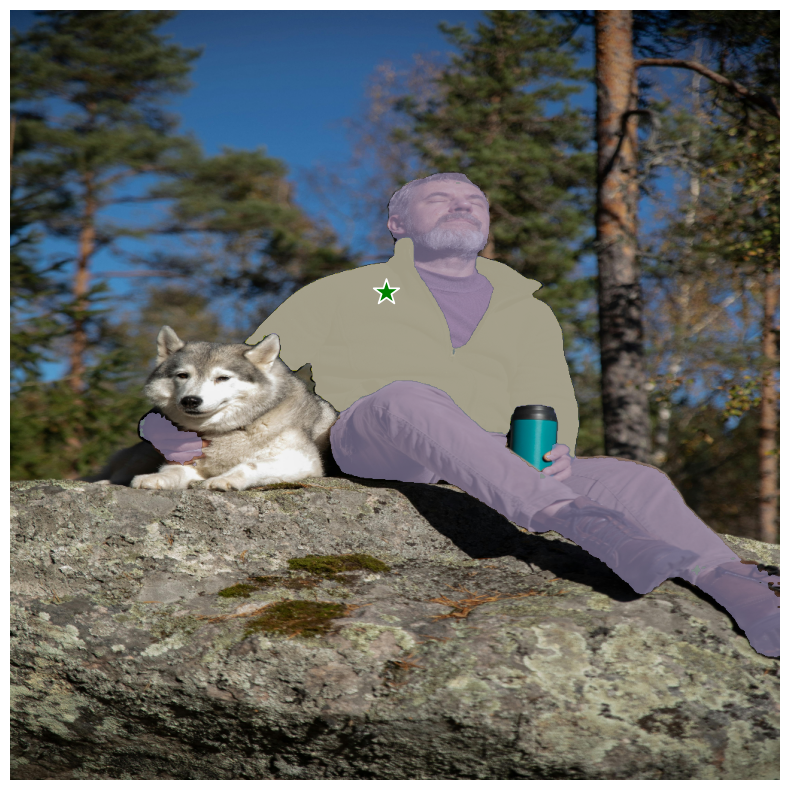

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

image = cv2.imread('./SAM_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))

model_type = "vit_l"
sam_checkpoint = f"./sam_vit_l_0b3195.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[500, 375]])
input_label = np.array([1])

# 进行分割
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)

show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## 框提示分割

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

image = cv2.imread('./SAM_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))

model_type = "vit_l"
sam_checkpoint = f"./sam_vit_l_0b3195.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_box = np.array([400, 300, 800, 600])  # 替换为你的框坐标

# 5. 进行分割
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=True
)

# 6. 可视化结果
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[np.argmax(scores)], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## 直接分割所有

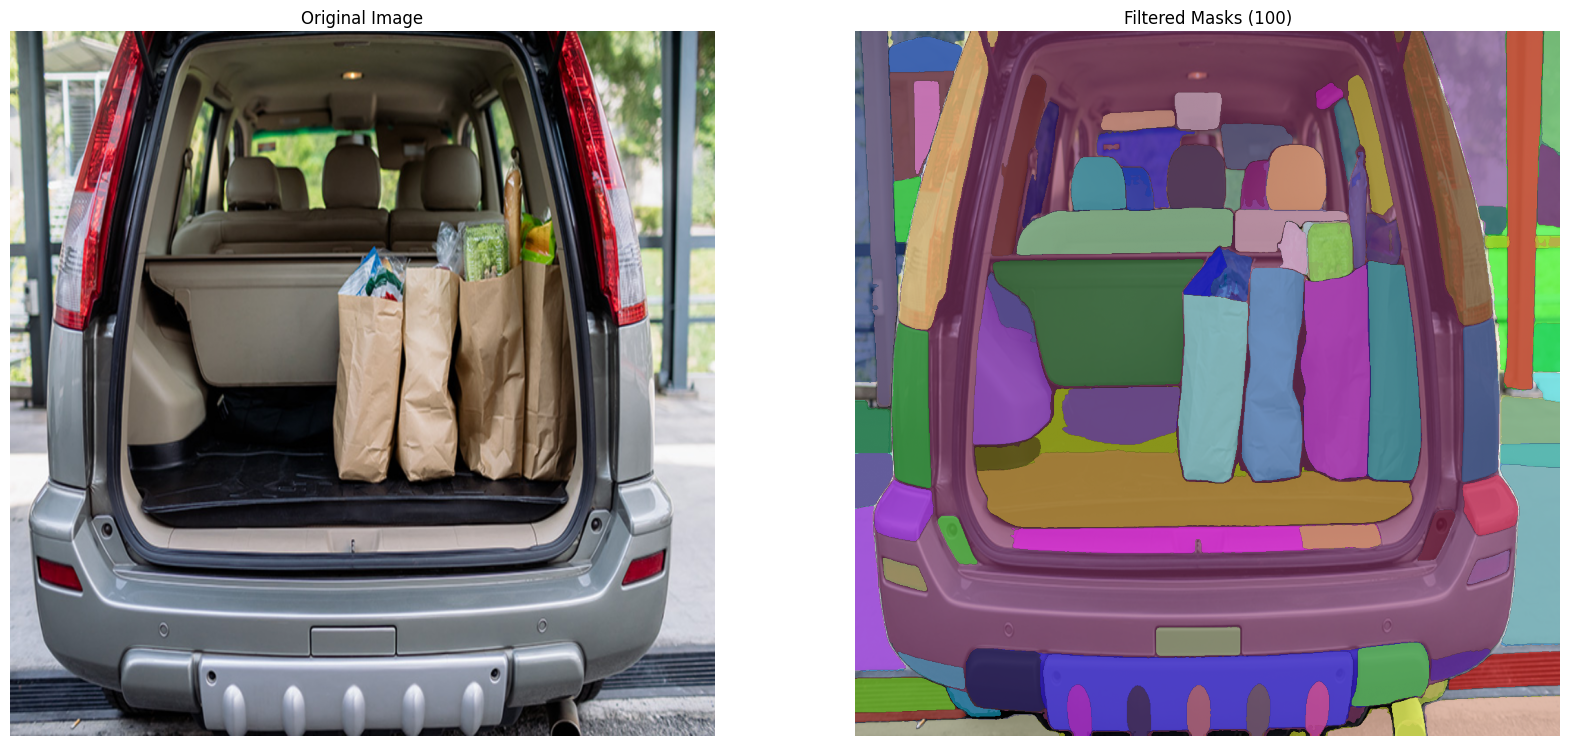

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

def show_anns(anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for ann in sorted_anns:
        m = ann['segmentation']
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        mask_image = m.reshape(m.shape[0], m.shape[1], 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

def save_masks(anns, output_dir, image_name):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, ann in enumerate(anns):
        mask = ann['segmentation'].astype(np.uint8) * 255
        cv2.imwrite(os.path.join(output_dir, f"{image_name}_mask_{i}.png"), mask)

# 1. 加载图片
image = cv2.imread('./groceries.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))

# 2. 加载 SAM 模型
sam_checkpoint = "./sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# 3. 初始化自动掩码生成器
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,                      # 网格点密度，越大越细致
    pred_iou_thresh=0.85,                    # 预测 IoU 阈值，过滤低质量掩码
    stability_score_thresh=0.9,              # 稳定性分数阈值
    min_mask_region_area=100                 # 最小掩码面积（像素）
)

masks = mask_generator.generate(image)

filtered_masks = [
    mask for mask in masks
    if mask['area'] > 1000 and mask['predicted_iou'] > 0.9
]

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image)
show_anns(filtered_masks, plt.gca())
plt.title(f'Filtered Masks ({len(filtered_masks)})')
plt.axis('off')

plt.show()

# Clip代码测试

In [2]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install Pillow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c_2yyq19
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-c_2yyq19
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 539.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 4.1 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.4 MB/s eta 0:00:00
     ━━

In [13]:
!aria2c -x 16 "https://openaipublic.blob.core.windows.net/clip/models/ViT-B-32.pt"

/bin/bash: line 1: aria2c: command not found


In [ ]:
import os
import clip
import torch
import cv2
from PIL import Image
import numpy as np
from transformers import CLIPModel, CLIPProcessor
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
# 1. 加载 CLIP 模型和预处理器
cache_dir = './'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, processor = clip.load("ViT-B/32", 
                              device=device,
                              download_root= cache_dir)
# 直接使用hugging face进行下载
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32",
#                                   cache_dir= cache_dir)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32",
#                                           cache_dir= cache_dir)

# 2. 加载图像
image_path = "./SAM_image.jpg"
image = cv2.imread(image_path)
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
image_input = processor(image).unsqueeze(0).to(device)

# 3. 定义文本描述
text_labels = [f"This is a {_}" for _ in ["cat", "dog", "car", "tree", "people"]]
text_inputs = clip.tokenize(text_labels).to(device)

# 4. 提取特征并计算相似度
with torch.no_grad():
    image_features = model.encode_image(image_input)  # 图像嵌入
    text_features = model.encode_text(text_inputs)    # 文本嵌入
    print(f"The Image Features Shape: {image_features.shape}; The Text Features Shape: {text_features.shape}")
    logits_per_image, logits_per_text = model(image_input, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # 分类概率

# 5. 输出结果
print("Label probabilities:")
for label, prob in zip(text_labels, probs[0]):
    print(f"{label}: {prob:.4f}")

The Image Features Shape: torch.Size([1, 512]); The Text Features Shape: torch.Size([5, 512])
tensor([[17.7344],
        [20.8750],
        [16.3906],
        [18.2969],
        [19.7031]], device='cuda:0', dtype=torch.float16)
Label probabilities:
This is a cat: 0.0300
This is a dog: 0.6943
This is a car: 0.0078
This is a tree: 0.0527
This is a people: 0.2151


# 组合拳  
**下面代码建议直接到.py文件然后运行**，除此之外在将Clip和LLM集合使用，生成的内容都是 **一派胡言**（因为LLM只能收到Clip给出的文本描述，不知道具体图像特征因此就会一派胡言），可以选择进行微调（可能需要写一个 映射层保证特征可以对齐，其实就是将编码后image作为一个"文本进行输入"）然后测试效果可能会好一点具体代码见（**通过Claude生成没有实际测试**）：

## Clip+SAM

In [ ]:
import numpy as np
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os
import gc

def show_anns(anns, ax, image):
    """显示分割掩码"""
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for ann in sorted_anns:
        m = ann['segmentation']
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        mask_image = m.reshape(m.shape[0], m.shape[1], 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

def save_masks(anns, output_dir, image_name):
    """保存掩码为 PNG 文件"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, ann in enumerate(anns):
        mask = ann['segmentation'].astype(np.uint8) * 255
        cv2.imwrite(os.path.join(output_dir, f"{image_name}_mask_{i}.png"), mask)

def crop_image_by_mask(image, mask, bbox, min_size=224):
    """根据掩码裁剪图像区域，必要时放大到最小尺寸"""
    x, y, w, h = bbox
    masked_image = image.copy()
    masked_image[~mask] = 0
    cropped_image = masked_image[y:y+h, x:x+w]
    
    # 如果裁剪区域太小，放大到 min_size
    if min(w, h) < min_size:
        scale = min_size / min(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        cropped_image = cv2.resize(cropped_image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    
    return cropped_image

def resize_image(image, max_size=1280, min_size=512):
    """将图像缩放到合适尺寸，保持宽高比"""
    h, w = image.shape[:2]
    max_dim = max(h, w)
    if max_dim > max_size:
        scale = max_size / max_dim
        new_h, new_w = int(h * scale), int(w * scale)
    elif max_dim < min_size:
        scale = min_size / max_dim
        new_h, new_w = int(h * scale), int(w * scale)
    else:
        return image
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

def free_cuda_memory(cuda_items: list):
    """释放显存占用"""
    for item in cuda_items:
        del item
    torch.cuda.empty_cache()
    gc.collect()

def draw_annotated_image(image, filtered_masks, output_dir, image_name):
    """在原始图像上绘制掩码、边界框和类别标签，并保存结果"""
    annotated_image = image.copy()
    
    for mask in filtered_masks:
        m = mask['segmentation']
        color = np.random.random(3) * 255  # 随机颜色 (BGR)
        mask_image = np.zeros_like(image)
        mask_image[m] = color
        annotated_image = cv2.addWeighted(annotated_image, 1.0, mask_image, 0.4, 0.0)
        
        x, y, w, h = mask['bbox']
        cv2.rectangle(annotated_image, (x, y), (x + w, y + h), color, 2)
        
        label = f"{mask['predicted_class']} ({mask['class_prob']:.2f})"
        cv2.putText(
            annotated_image,
            label,
            (x, max(y - 10, 10)),  # 避免标签越界
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            1,
            cv2.LINE_AA
        )
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, f"{image_name}_annotated.png")
    cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    
    return annotated_image

def segment_and_classify(image_path, target_classes, 
                        sam_checkpoint="path/to/sam_vit_b_01ec64.pth", 
                        model_type="vit_b", 
                        clip_model="ViT-B/32", 
                        output_dir="output_masks", 
                        max_image_size=1280, 
                        prob_threshold=0.5,
                        cache_dir='./'):
    """
    使用 SAM 分割图像并用 CLIP 分类，筛选指定类别的掩码，优化分辨率和显存
    
    参数:
        image_path (str): 图像路径
        target_classes (list): 目标类别列表，如 ["a cat", "a dog"]
        sam_checkpoint (str): SAM 模型 checkpoint 路径
        model_type (str): SAM 模型类型，如 "vit_b"
        clip_model (str): CLIP 模型类型，如 "ViT-B/32"
        output_dir (str): 输出掩码保存目录
        max_image_size (int): 图像最大尺寸，控制显存
        prob_threshold (float): CLIP 分类概率阈值
        cache_dir (str): CLIP 模型缓存目录
    
    返回:
        filtered_masks: 筛选后的掩码列表
    """
    # 验证 model_type 是否与 sam_checkpoint 匹配
    if model_type not in sam_checkpoint:
        raise ValueError(f"Model type {model_type} does not match checkpoint {sam_checkpoint}")

    # 1. 加载并预处理图像
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load image from {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_image(image, max_size=max_image_size, min_size=512)
    
    # 2. 加载 SAM 模型并生成掩码
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16,
        pred_iou_thresh=0.85,
        stability_score_thresh=0.9,
        min_mask_region_area=200  # 提高面积阈值，过滤小区域
    )
    
    masks = mask_generator.generate(image)
    free_cuda_memory([sam, mask_generator])
    
    # 3. 加载 CLIP 模型
    clip_model, preprocess = clip.load(clip_model, device=device, download_root=cache_dir)
    text_inputs = clip.tokenize(target_classes).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    
    # 4. 对每个掩码区域进行分类，过滤小区域
    filtered_masks = []
    for mask in masks:
        x, y, w, h = mask['bbox']
        if min(w, h) < 100:  # 过滤边界框过小的区域
            continue
        cropped_image = crop_image_by_mask(image, mask['segmentation'], mask['bbox'], min_size=224)
        if cropped_image.size == 0:
            continue
        pil_image = Image.fromarray(cropped_image)
        image_input = preprocess(pil_image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
            logits_per_image = (image_features @ text_features.T).softmax(dim=-1)
            probs = logits_per_image.cpu().numpy()[0]
        
        max_prob_idx = np.argmax(probs)
        if probs[max_prob_idx] > prob_threshold:
            mask['predicted_class'] = target_classes[max_prob_idx]
            mask['class_prob'] = probs[max_prob_idx]
            filtered_masks.append(mask)
        
        free_cuda_memory([image_input])
    
    free_cuda_memory([clip_model, text_features])
    # # 5. 可视化结果
    # plt.figure(figsize=(20, 10))
    
    # plt.subplot(1, 2, 1)
    # plt.imshow(image)
    # plt.title('Original Image')
    # plt.axis('off')
    
    # plt.subplot(1, 2, 2)
    # plt.imshow(image)
    # show_anns(filtered_masks, plt.gca(), image)
    # plt.title(f'Filtered Masks ({len(filtered_masks)})')
    # plt.axis('off')
    
    # plt.show()
    
    # # 6. 绘制带掩码和标签的图像
    # image_name = os.path.basename(image_path).split('.')[0]
    # annotated_image = draw_annotated_image(image, filtered_masks, output_dir, image_name)
    
    # # 7. 保存单独的掩码
    # save_masks(filtered_masks, output_dir, image_name)
    
    # 8. 打印分类结果
    for i, mask in enumerate(filtered_masks):
        print(f"Mask {i}: Class = {mask['predicted_class']}, Probability = {mask['class_prob']:.4f}")
    
    return filtered_masks

if __name__ == "__main__":
    image_path = "./SAM_image.jpg"
    target_classes = ["a cat", "a dog"]
    filtered_masks = segment_and_classify(
        image_path, 
        target_classes, 
        sam_checkpoint='./sam_vit_l_0b3195.pth', 
        model_type='vit_l',
        output_dir="output_masks",
        max_image_size=1280
    )

SyntaxError: invalid syntax (3818404211.py, line 217)

## Clip+LLM

In [ ]:
import numpy as np
from vllm import LLM, SamplingParams
import torch
import cv2
from PIL import Image
import clip
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

def load_clip_model(model_name="ViT-B/32", 
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    download_root= './'):
    """加载 CLIP 模型和预处理器"""
    model, preprocess = clip.load(model_name, device=device,
                                  download_root= download_root)
    return model, preprocess

def load_vllm_model(model_name="Qwen/Qwen2-0.5B-Instruct", max_model_len=2048):
    """加载 vLLM 模型"""
    llm = LLM(
        model=model_name,
        dtype="float16",
        max_model_len=max_model_len,
        enforce_eager=True,
        trust_remote_code=True,
    )
    return llm

def resize_image(image, max_size=512, min_size=256):
    """将图像缩放到合适尺寸，保持宽高比"""
    h, w = image.shape[:2]
    max_dim = max(h, w)
    if max_dim > max_size:
        scale = max_size / max_dim
        new_h, new_w = int(h * scale), int(w * scale)
    elif max_dim < min_size:
        scale = min_size / max_dim
        new_h, new_w = int(h * scale), int(w * scale)
    else:
        return image
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

def free_cuda_memory(items: list):
    """释放显存占用"""
    for item in items:
        del item
    torch.cuda.empty_cache()

def generate_image_description(image_path, 
                               target_classes, 
                               clip_model_name="ViT-B/32", 
                               llm_model_name="Qwen/Qwen2-0.5B-Instruct",
                               max_image_size=512, 
                               prob_threshold=0.5, 
                               output_dir="output",
                               cache_dir= './'):
    """
    使用 CLIP 分类图像内容，vLLM 加速 LLM 生成描述（零样本）
    
    参数:
        image_path (str): 图像路径
        target_classes (list): 候选类别列表，如 ["a cat", "a dog"]
        clip_model_name (str): CLIP 模型类型
        llm_model_name (str): LLM 模型类型
        max_image_size (int): 图像最大尺寸，控制显存
        prob_threshold (float): CLIP 分类概率阈值
        output_dir (str): 输出目录
    
    返回:
        description (str): LLM 生成的图像描述
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load image from {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_image(image, max_size=max_image_size, min_size=256)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, preprocess = load_clip_model(clip_model_name, device,
                                             download_root= cache_dir)
    image_input = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
    text_inputs = clip.tokenize(target_classes).to(device)
    
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_inputs)
        logits_per_image = (image_features @ text_features.T).softmax(dim=-1)
        probs = logits_per_image.cpu().numpy()[0]
    
    max_prob_idx = np.argmax(probs)
    if probs[max_prob_idx] < prob_threshold:
        predicted_class = "unknown object"
    else:
        predicted_class = target_classes[max_prob_idx]
    
    free_cuda_memory([clip_model, image_input, text_inputs, image_features, text_features])

    llm = load_vllm_model(llm_model_name, max_model_len=2048)
    prompt = f"[INST] The image contains {predicted_class}. Please provide a detailed description of this scene in one paragraph. [/INST]"
    sampling_params = SamplingParams(
        temperature=0.7,
        top_p=0.9,
        max_tokens=100
    )
    outputs = llm.generate([prompt], sampling_params)
    description = outputs[0].outputs[0].text
    
    del llm
    torch.cuda.empty_cache()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    image_name = os.path.basename(image_path).split('.')[0]
    with open(os.path.join(output_dir, f"{image_name}_description.txt"), "w") as f:
        f.write(description)
    
    print(f"Predicted class: {predicted_class} (Probability: {probs[max_prob_idx]:.4f})")
    print(f"Description: {description}")
    return description

if __name__ == "__main__":
    image_path = "./SAM_image.jpg"
    target_classes = ["a cat", "a dog", "a car", "a tree"]
    description = generate_image_description(
        image_path,
        target_classes,
        clip_model_name="ViT-B/32",
        llm_model_name="Qwen/Qwen2-0.5B-Instruct",
        max_image_size=512,
        output_dir="output"
    )

# 代码使用说明
## SAM模型使用说明  
```python
# 克隆SAM仓库
git clone https://github.com/facebookresearch/segment-anything.git
cd segment-anything
pip install -e .

# 安装依赖
pip install opencv-python pycocotools matplotlib onnxruntime onnx
```
不同的SAM模型权重（**模型权重大小依次递减**）：  
vit_h: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth  
vit_l: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth  
vit_b: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth  
官方给出的代码实践操作中SAM提到了两种标记模式：1、点提示分割；2、标记框提示分割两种。如果实际应用可能会**将SAM作为一个数据标记工具**进行使用，因此一般会选择全部标记的方式进行处理。  
### SAM基本使用
```python
# 首先是加载模型
sam_checkpoint = "./sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# 模型初始化
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,                      # 网格点密度，越大越细致
    pred_iou_thresh=0.85,                    # 预测 IoU 阈值，过滤低质量掩码
    stability_score_thresh=0.9,              # 稳定性分数阈值
    min_mask_region_area=100                 # 最小掩码面积（像素）
)
# 生成所有的mask内容
masks = mask_generator.generate(image)
```
一般来说SAM只能做到对所有的内容进行分割，也就是说将一张图片上的所有内容分割出来，但是SAM模型自身是无法知道划分出来到底是个什么东西，因此**还需要结合一个分类模型去对分类好的所有内容进行分类**。除此之外了解一下SAM模型都输出点什么东西还是有必要的。生成所有的`masks`（一个 list 对象）内容之后，得到所有的keys（`masks[0].keys()`）为：`['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']`分别代表的含义是：
| Key                | 含义                              | 类型               | 值示例/说明                                      |
|--------------------|----------------------------------|--------------------|------------------------------------------------|
| `segmentation`     | 二值掩码，表示对象区域            | `np.ndarray` (bool) | 形状为 `(H, W)`，`True` 表示对象区域，`False` 表示背景 |
| `area`             | 掩码的像素面积                   | `int`              | 像素数量，如 `1500`                             |
| `bbox`             | 掩码的边界框                     | `list` [x, y, w, h] | `[100, 200, 50, 60]`，表示左上角坐标和宽高      |
| `predicted_iou`    | 预测的分割质量（IoU 分数）        | `float`            | 范围 `[0, 1]`，如 `0.92`，越高表示分割越可靠     |
| `point_coords`     | 生成掩码时使用的参考点坐标        | `np.ndarray`       | 形状 `(1, 2)`，如 `[[500, 375]]`                |
| `stability_score`  | 掩码的稳定性分数                 | `float`            | 范围 `[0, 1]`，如 `0.95`，越高表示掩码越稳定    |
| `crop_box`         | 裁剪框（若使用裁剪）             | `list` [x, y, w, h] | `[0, 0, 1024, 1024]`，若无裁剪则为图像全尺寸   |


## Clip模型使用说明
```python
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision # 如果有不需要下载
!pip install Pillow
model, processor = clip.load("ViT-B/32", 
                              device=device,
                              download_root= cache_dir) # 下载不同的模型权重
```
不过值得注意的是在Clip中只能处理一些比较简单的 **图像——文本**任务，对于复杂的可能效果就没有那么好
### Clip基本使用
```python
text_labels = [f"This is a {_}" for _ in ["cat", "dog", "car", "tree", "people"]]
text_inputs = clip.tokenize(text_labels).to(device)

# 4. 提取特征并计算相似度
with torch.no_grad():
    image_features = model.encode_image(image_input)  # 图像嵌入 torch.Size([1, 512])
    text_features = model.encode_text(text_inputs)    # 文本嵌入 torch.Size([5, 512])
```
这样一来得到结果为：`The Image Features Shape: torch.Size([1, 512]); The Text Features Shape: torch.Size([5, 512])`
> 不过值得注意的是不用Clip权重得到的特征是不一样的（*From Grok*）  
> ![2AD5-4E6E-A78E-26446F935D77}.png](https://2.z.wiki/autoupload/20250525/E2AD/761X408/%7B894328C4-2AD5-4E6E-A78E-26446F935D77%7D.png)  
> ![EA61-4B60-A746-ED190DC5106F}.png](https://2.z.wiki/autoupload/20250525/audn/749X415/%7B80A24297-EA61-4B60-A746-ED190DC5106F%7D.png) 

因此如果多模态任务或者Condiction Diffusion任务一般就可以直接调用上面两个encode编码然后进行其他操作了
# 总结
对于SAM而言更加喜欢将他作为一个数据标记工具，对于Clip而言更加喜欢将它作为一个 **图像——文本**编码器（模型能够较好的理解图像和文本内容，并且可以很好的对其这两部分的特征信息）这两种模型很少会选择将他们单独（仅仅只从多模态任务而言）进行使用（毕竟不够 “多模态”）